<a href="https://colab.research.google.com/github/russell-ai/SparkNLP-CustomNER/blob/main/2_CoNLL_File_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# **Interview Task**
[Running a Spark NLP Healthcare Pipeline and Training a Custom NER Model](https://docs.google.com/document/d/1l_SpYGAlVGAEe9x-b8avgvKipCXetdap2ttc4UKreO4/edit?tab=t.0)  
## **PART-II CoNLL File Generation:**  
In this second part, we are going to create a CoNLL file using the NER tags and texts that we have obtained in the first part.


## Setup and imports

In [1]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.8/620.8 kB 34.4 MB/s eta 0:00:00


In [2]:
import json
import os

import pandas as pd
from tqdm import tqdm
from collections import Counter

import sparknlp
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *
from sparknlp.training import CoNLL

import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


spark = sparknlp.start()

print ("Spark NLP Version :", sparknlp.version())

spark

Spark NLP Version : 5.5.0


## **Convert the predictions (NER tags) from Spark NLP models into the CoNLL format.**

In [3]:
# You can either upload the files manually or download them from the link
!wget -q https://raw.githubusercontent.com/russell-ai/SparkNLP-CustomNER/refs/heads/main/ner_clinical_mtsamples_ner_results_for_conll.csv -O /content/ner_clinical_mtsamples_ner_results_for_conll.csv
!wget -q https://raw.githubusercontent.com/russell-ai/SparkNLP-CustomNER/refs/heads/main/mtsamples_texts.csv -O /content/mtsamples_texts.csv

### **Entity File**
This dataframe should include at least five  below columns in order:
*   `['text_id','begin','end','chunk','entity']`

In [6]:
import pandas as pd
train_entities_df = pd.read_csv('/content/ner_clinical_mtsamples_ner_results_for_conll.csv')
train_entities_df= train_entities_df[["text_id", "begin", "end", "chunk", "entity"]]
train_entities_df.head()

,text_id,begin,end,chunk,entity
0,0,88,99,Mesothelioma,PROBLEM
1,0,118,129,Mesothelioma,PROBLEM
2,0,132,147,pleural effusion,PROBLEM
3,0,150,168,atrial fibrillation,PROBLEM
4,0,171,176,anemia,PROBLEM


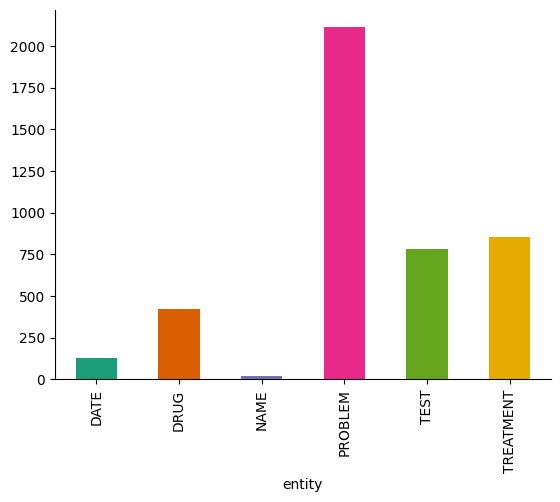

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
train_entities_df.groupby('entity').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### **Text File**
This dataframe should include at least two below columns in order:
*   `['text_id','text']`

In [8]:
train_text_df = pd.read_csv('/content/mtsamples_texts.csv')
train_text_df.head()

,text_id,text
0,0,Sample Type / Medical Specialty:\nHematology -...
1,1,Sample Type / Medical Specialty:\nHematology -...
2,2,Sample Type / Medical Specialty:\nHematology -...
3,3,Sample Type / Medical Specialty:\nHematology -...
4,4,Sample Type / Medical Specialty:\nHematology -...


In [13]:
print(train_text_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text_id  50 non-null     int64 
 1   text     50 non-null     object
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes
None


## **CoNLL Builder**

In [27]:
def make_conll(text:pd.DataFrame, entity:pd.DataFrame,
               save_tag:bool=None,
               save_conll:bool=None,
               verbose:bool=None,
               begin_deviation:int=0,
               end_deviation:int=0 )->str:

    df_text = text.iloc[:,[0,1]]
    df_entity = entity.iloc[:,[0,1,2,3,4]]
    df_text.columns = ['text_id','text']
    df_entity.columns = ['text_id','begin','end','chunk','entity']
    entity_list = list(df_entity.entity.unique())


    ########--------------1.tag transformation function------------########

    def transform_text(text, entities, verbose=None):

        tag_list=[]
        for entity in entities.iterrows():

            begin = entity[1][1] if entity[1][1] == 0 else entity[1][1] + begin_deviation
            end = entity[1][2] + end_deviation
            chunk = entity[1][3]
            tag = entity[1][4]
            text = text[:end] + f' </END_NER:{tag}> ' + text[end:]
            text = text[:begin] + f' <START_NER:{tag}> ' + text[begin:]
            tag_list.append(tag)

        sum_of_added_entity = Counter(tag_list)
        sum_of_entity = Counter(entities['entity'].values)

        if verbose:
            print(f'Processed text id   : {entities.text_id.values[:1]}')
            print(f'Original Entities   : {sum_of_entity}\nAdded Entities      : {sum_of_added_entity}')
            print(f'Number Equality     : {sum_of_added_entity == sum_of_entity}')
            print("=="*40)

        if not sum_of_entity == sum_of_added_entity:
            print("There is a problem in text id:")
            print(entities.text_id.values[0])
            raise Exception("Check this text!")

        return text


    ######---------------2.apply_transform_text function ----------------#######

    def apply_tag_ner(df_text, df_entity, save=None, verbose=None):

        for text_id in tqdm(df_text.text_id):
            text  = df_text.loc[df_text['text_id']==text_id]['text'].values[0]
            entities  = df_entity.loc[(df_entity['text_id']==text_id)].sort_values(by='begin',ascending=False)

            df_text.loc[df_text['text_id']==text_id, 'text'] = transform_text(text, entities, verbose=verbose)

        if save:
            df_text.to_csv("text_with_ner_tag.csv", index=False, encoding='utf8')

        return df_text


    ##########----------------3.RUNNING TAG FUNCTION---------------#############

    print("Text tagging starting. Applying entities to whole text...\n")
    df = apply_tag_ner(df_text, df_entity, save=save_tag, verbose=verbose)


    ###########---------------4.Spark Pipeline-----------------------###########

    def spark_pipeline(df):
        spark_df = spark.createDataFrame(df)

        documentAssembler = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")\
            .setCleanupMode("shrink")

        sentenceDetector = SentenceDetector()\
            .setInputCols(['document'])\
            .setOutputCol('sentences')\
            .setExplodeSentences(True)

        tokenizer = Tokenizer() \
            .setInputCols(["sentences"]) \
            .setOutputCol("token")

        nlpPipeline = Pipeline(stages=[documentAssembler, sentenceDetector, tokenizer ])

        empty_df = spark.createDataFrame([['']]).toDF("text")
        pipelineModel = nlpPipeline.fit(empty_df)

        result = pipelineModel.transform(spark_df.select(['text']))


        return result.select('token.result').toPandas()
    print("\n\nSpark pipeline is running...")
    df_final = spark_pipeline(df)


    #########--------------5.CoNLL Function--------------------#############

    def build_conll(df_final, tag_list, save=None):

        header = "-DOCSTART- -X- -X- O\n\n"
        conll_text = ""
        chunks = []
        tag_list = tag_list
        tag = 'O'      # token tag
        ct = 'B'       # chunk tag part B or I

        for sentence_tokens in tqdm(df_final.result[:]):
            for token in sentence_tokens:
                if token.startswith("<START_NER:"):
                    tag = token.split(':')[1][:-1]
                    if tag not in tag_list:
                        tag = 'O'
                        conll_text += f'{token} NN NN {tag}\n'

                    continue

                if token.startswith("</END_NER:") and tag != 'O':
                    for i, chunk in enumerate(chunks):
                        ct = 'B' if i == 0 else 'I'
                        conll_text += f'{chunk} NNP NNP {ct}-{tag}\n'

                    chunks=[]
                    tag='O'
                    continue

                if tag != 'O':
                    chunks.append(token)
                    continue

                if tag == 'O':
                    conll_text += f'{token} NN NN {tag}\n'
                    continue

            conll_text += '\n'

        if save:
            with open("conll2003_text_file.conll", "w+", encoding='utf8') as f:
                f.write(header)
                f.write(conll_text)

        print("\nDONE!")
        return conll_text


    ########----------------6.RUNNING CONLL FUNCTION--------------------########

    print("Conll file is being created...\n")
    return build_conll(df_final, tag_list=entity_list, save=save_conll)


### Running the CoNLL Builder

In [28]:
# if you want tagged text or conll file saved in the current directory: just make default 'save_tag' or 'save_conll' parameters True.
# For the purpose of offset callibration, set 'end_deviation' parameter to 1.
conll_text = make_conll(train_text_df, train_entities_df, save_conll=True, end_deviation=1)

Text tagging starting. Applying entities to whole text...



  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-27-bb890bb33098>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  begin = entity[1][1] if entity[1][1] == 0 else entity[1][1] + begin_deviation
<ipython-input-27-bb890bb33098>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = entity[1][2] + end_deviation
<ipython-input-27-bb890bb33098>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chunk = entity[1][3]
<ipython-input-27-



Spark pipeline is running...
Conll file is being created...



100%|██████████| 2425/2425 [00:00<00:00, 49011.86it/s]


DONE!


In [29]:
# Checking conll string
print(conll_text[:615])

Sample NN NN O
Type NN NN O
/ NN NN O
Medical NN NN O
Specialty NN NN O
: NN NN O
Hematology NN NN O
- NN NN O
Oncology NN NN O
Sample NN NN O
Name NN NN O
: NN NN O
Discharge NN NN O
Summary NN NN O
- NN NN O
Mesothelioma NNP NNP B-PROBLEM
- NN NN O
1 NN NN O
Description NN NN O
: NN NN O
Mesothelioma NNP NNP B-PROBLEM
, NN NN O
pleural NNP NNP B-PROBLEM
effusion NNP NNP I-PROBLEM
, NN NN O
atrial NNP NNP B-PROBLEM
fibrillation NNP NNP I-PROBLEM
, NN NN O
anemia NNP NNP B-PROBLEM
, NN NN O
ascites NNP NNP B-PROBLEM
, NN NN O
esophageal NNP NNP B-PROBLEM
reflux NNP NNP I-PROBLEM
, NN NN O
and NN NN O
history


### Saving CoNLL File

In [ ]:
# if save_conll parameter is True then the conll file already saved in the current directory
with open("conll2003_text_file.conll", "w+", encoding='utf8') as f:
    f.write("-DOCSTART- -X- -X- O\n\n")
    f.write(conll_text)

# Reading CoNLL File by using CoNLL Reader

In [30]:
data = CoNLL().readDataset(spark, "/content/conll2003_text_file.conll")
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Sample Type / Med...|[{document, 0, 25...|[{document, 0, 25...|[{token, 0, 5, Sa...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|( Medical Transcr...|[{document, 0, 75...|[{document, 0, 75...|[{token, 0, 0, (,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
|SECONDARY DIAGNOS...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 8, SE...|[{pos, 0, 8, NN, ...|[{named_entity, 0...|
|          PROCEDURES|[{document, 0, 9,...|[{document, 0, 9,...|[{token, 0, 9, PR...|[{pos, 0, 9, NN, ...|[{named_entity, 0...|
|1 . On August 24 ...|[{document, 0, 10...|[{document, 0, 10...|[{token, 0, 0, 1,...|[{pos, 0, 0, NN, ..

In [33]:
from pyspark.sql import functions as F

data.select(F.explode(F.arrays_zip(data.token.result,
                                         data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |25531|
|I-PROBLEM   |3128 |
|B-PROBLEM   |2111 |
|I-TREATMENT |1098 |
|I-TEST      |905  |
|B-TREATMENT |854  |
|B-TEST      |779  |
|B-DRUG      |424  |
|I-DRUG      |261  |
|B-DATE      |130  |
|I-DATE      |48   |
|B-NAME      |19   |
|I-NAME      |9    |
+------------+-----+



### Reading CoNLL File by using Pandas

In [40]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = ' ', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3,
                     skip_blank_lines = False,
                     encoding="utf8")
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART-')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

In [41]:
conll_df = read_conll('/content/conll2003_text_file.conll')

In [47]:
conll_df.value_counts('labels')

,count
labels,
O,25531
I-PROBLEM,3128
B-PROBLEM,2111
I-TREATMENT,1098
I-TEST,905
B-TREATMENT,854
B-TEST,779
B-DRUG,424
I-DRUG,261




---
***R.Caliskan***
